
<h1 align="center">Assignment 2</h1>
<h3 style="display:block; margin-top:5px;" align="center">Online Tracking and Privacy</h3>    
<br>

In [2]:
import os
from collections import defaultdict
import seaborn as sns
import pandas as pd
import json
import tldextract
from datetime import datetime

In [78]:
"""
This function loads the har files obtained from the website
"""
def load_file(path):
    with open(path, 'r', encoding='utf-8') as file:
        return json.load(file)

"""
This function obtains the domains of the urls.
"""
def extract_domain_info(url):
    domain_info = tldextract.extract(url)
    return domain_info.registered_domain

"""
This function obtains the entity_name of the organization that owns the domain names of the request urls
"""
def extract_entity_name(domain, entity_map):
    domain_info = tldextract.extract(domain)
    registered_domain = domain_info.registered_domain
    return entity_map.get(registered_domain, {"entityName": "Unknown"})["entityName"]

"""
Load in all the har files.
"""
def load_har_files(directory):
    hars_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.har'):
            file_path = os.path.join(directory, filename)
            file_path = file_path.replace("\\", "/")

            har_data = load_file(file_path)
            hars_data.append(har_data)

    return hars_data


"""
Load disconnect's block list domains
"""
def load_block_list():
    with open("../utils/services.json", "r", encoding="utf-8") as f:
        blocklist_data = json.load(f)

    block_list = []

    for category_name, category_data in blocklist_data['categories'].items():
        for entry in category_data:
            for _company_name, domains in entry.items():
                for _domain, block_domains in domains.items():
                    if isinstance(block_domains, list):
                        block_list.extend(block_domains)

    return list(set(block_list))

In [79]:
# Open document with the statistics of the crawler
stats = load_file("../analysis/stats-2024-04-10 06:39:16.228163.json")

# Load in all the har files
hars_allow = load_har_files('../crawl_data_allow')
hars_block = load_har_files('../crawl_data_block')

disconnect_domains = load_block_list()

### Exercise 1

In [80]:
data = {
    'Error type': ['Page load timeout', 'Consent click failure'],
    'Crawl-Accept': [len(stats['page_load_timeout_allow']), len(stats['consent_click_failure_allow'])],
    'Crawl-Block': [len(stats['page_load_timeout_block']), len(stats['consent_click_failure_block']) ]
}
pd.DataFrame(data)

,Error type,Crawl-Accept,Crawl-Block
0,Page load timeout,8,7
1,Consent click failure,28,30


## Exercise 2

- Page load time

In [81]:
page_load_times_allow = [(url_time['page_load_time'], 'Allow') for url_time in stats["page_load_times_allow"]]
page_load_times_block = [(url_time['page_load_time'], 'Block') for url_time in stats["page_load_times_block"]]

<Axes: xlabel='Crawl Type', ylabel='Page load time'>

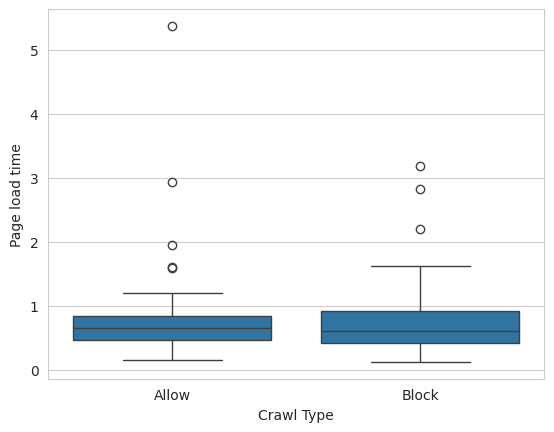

In [82]:
df_page_load_times = pd.DataFrame(page_load_times_allow + page_load_times_block, columns=['Page load time', 'Crawl Type'])
sns.set_style("whitegrid")
sns.boxplot(x = 'Crawl Type', y = 'Page load time', data = df_page_load_times)

- Number of requests

In [83]:
def gather_data(func_har, y_label):
    allow = [(count, 'Allow') for count in func_har(hars_allow)]
    block = [(count, 'Block') for count in func_har(hars_block)]
    return pd.DataFrame(allow + block, columns=[y_label, 'Crawl Type'])

In [84]:
def count_requests(hars):
    return [len(har['log']['entries']) for har in hars]

<Axes: xlabel='Crawl Type', ylabel='Number of requests'>

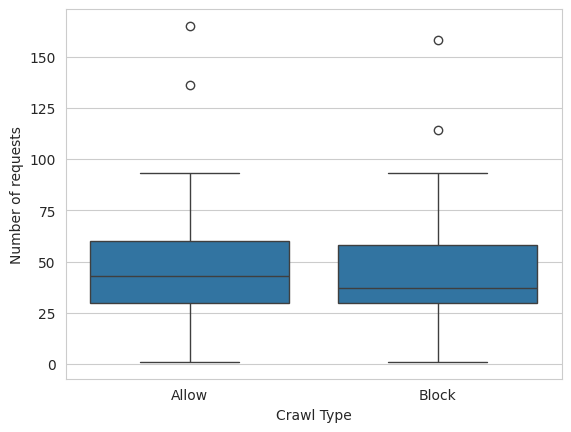

In [85]:
df_number_requests = gather_data(count_requests, 'Number of requests')
sns.set_style("whitegrid")
sns.boxplot(x = 'Crawl Type', y = 'Number of requests', data = df_number_requests)

- Numbers of distincs third party domains

In [92]:
def count_third_party(hars):
    third_party_counts = []

    for har in hars:
        main_url = har['log']['entries'][0]['request']['url']
        main_domain = extract_domain_info(main_url)

        third_party_domains = set()

        for entry in har['log']['entries'][1:]:
            url = entry['request']['url']
            domain = extract_domain_info(url)

            # blocked by block list
            if entry['response']['status'] == -1:
                continue

            if domain and domain != main_domain:
                third_party_domains.add(domain)

        third_party_counts.append(len(third_party_domains))

    return third_party_counts

<Axes: xlabel='Crawl Type', ylabel='Number of distinct third-party domains'>

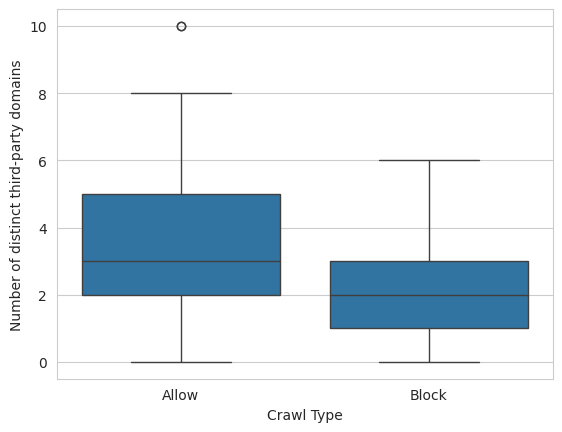

In [93]:
df_third_party = gather_data(count_third_party, 'Number of distinct third-party domains')
sns.set_style("whitegrid")
sns.boxplot(x = 'Crawl Type', y = 'Number of distinct third-party domains', data = df_third_party)

- Number of distinct tracker domains


In [94]:
def count_tracker_domains(hars):
    tracker_counts = []

    for har in hars:
        main_url = har['log']['entries'][0]['request']['url']
        main_domain = extract_domain_info(main_url)

        tracker_domains = set()

        for entry in har['log']['entries'][1:]:
            url = entry['request']['url']
            domain = extract_domain_info(url)

            # blocked by block list
            if entry['response']['status'] == -1:
                continue

            if domain and domain != main_domain and domain in disconnect_domains:
                tracker_domains.add(domain)

        tracker_counts.append(len(tracker_domains))

    return tracker_counts

<Axes: xlabel='Crawl Type', ylabel='Number of distinct tracker domains'>

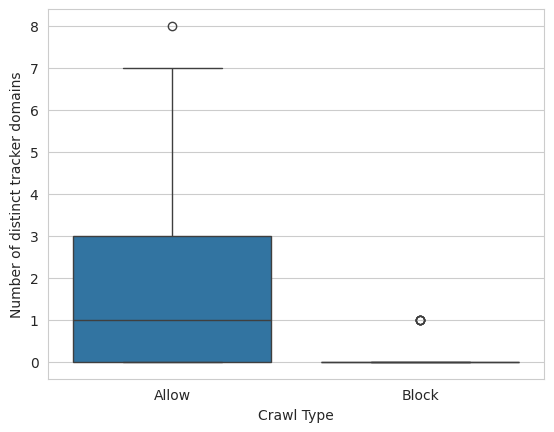

In [95]:
df_tracker_domain = gather_data(count_tracker_domains, 'Number of distinct tracker domains')
sns.set_style("whitegrid")
sns.boxplot(x = 'Crawl Type', y = 'Number of distinct tracker domains', data = df_tracker_domain)

- Number of distinct third-party domains that set a cookie with SameSite=None and without the partitioned attribute

In [96]:
def count_same_site(hars):
    third_party_counts = []

    for har in hars:
        main_url = har['log']['entries'][0]['request']['url']
        main_domain = extract_domain_info(main_url)

        third_party_domains = set()

        for entry in har['log']['entries'][1:]:
            url = entry['request']['url']
            domain = extract_domain_info(url)

            # blocked by block list
            if entry['response']['status'] == -1:
                continue

            if domain and domain != main_domain:
                cookie_response = entry['response'].get('cookies', [])
                for cookie in cookie_response:
                    if not cookie.get('Partitioned') and cookie.get('sameSite') == 'None':
                        third_party_domains.add(domain)

        third_party_counts.append(len(third_party_domains))

    return third_party_counts

<Axes: xlabel='Crawl Type', ylabel='Number of distinct third-party domains with cookie'>

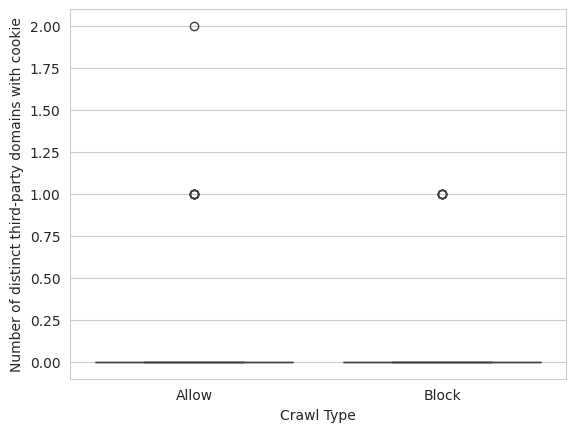

In [97]:
df_same_site = gather_data(count_same_site, 'Number of distinct third-party domains with cookie')
sns.set_style("whitegrid")
sns.boxplot(x = 'Crawl Type', y = 'Number of distinct third-party domains with cookie', data = df_same_site)

### Exercise 3


In [114]:
from statistics import median

dfs = [
    df_page_load_times,
    df_number_requests,
    df_third_party,
    df_tracker_domain,
    df_same_site,
]

header = [
    'Page load time (s)',
    'Number of requests',
    'Distinct third party domains',
    'Distinct tracker domains',
    'Distinct third party domains with cookie'
]

data = {'Metric': header}
measures = [min, median, max]

for crawl_type in ['Allow', 'Block']:
    for measure in measures:
        row = [measure(df[df['Crawl Type'] == crawl_type][df.columns[0]]) for df in dfs]
        data[crawl_type + ' ' + measure.__name__] = row

df = pd.DataFrame(data)
df = df.map(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
df

,Metric,Allow min,Allow median,Allow max,Block min,Block median,Block max
0,Page load time (s),0.156,0.656,5.369,0.125,0.608,3.186
1,Number of requests,1.000,43.000,165.000,1.000,37.000,158.000
2,Distinct third party domains,0.000,3.000,10.000,0.000,2.000,6.000
3,Distinct tracker domains,0.000,1.000,8.000,0.000,0.000,1.000
4,Distinct third party domains with cookie,0.000,0.000,2.000,0.000,0.000,1.000


### Exercise 4

In [117]:
def prevalent_third_party(hars):
    websites_tracker_info = {}

    for har in hars:
            main_url = har['log']['entries'][0]['request']['url']
            main_domain = extract_domain_info(main_url)

            for entry in har['log']['entries']:
                url = entry['request']['url']
                domain = extract_domain_info(url)

                if domain and domain != main_domain:
                    if domain not in websites_tracker_info:
                        websites_tracker_info[domain] = [1, 'Yes' if domain in disconnect_domains else 'No']
                    else:
                        websites_tracker_info[domain][0] += 1

    return websites_tracker_info

prevalent_allow = prevalent_third_party(hars_allow)
prevalent_block = prevalent_third_party(hars_block)

In [118]:
prevalent_allow = dict(sorted(prevalent_allow.items(), key=lambda x: x[1][0], reverse=True)[:10])
values_list = list(prevalent_allow.values())
data = {
    'Third-party domain': list(prevalent_allow.keys()),
    'Number of distinct websites (Crawl-allow)': [x[0] for x in values_list],
    'is Tracker?': [x[1] for x in values_list]}
pd.DataFrame(data)

,Third-party domain,Number of distinct websites (Crawl-allow),is Tracker?
0,piwik.pro,44,No
1,google-analytics.com,40,Yes
2,sim-cdn.nl,38,No
3,rijksoverheid.nl,35,No
4,siteimproveanalytics.io,34,Yes
5,googletagmanager.com,26,No
6,readspeaker.com,21,No
7,abtasty.com,21,Yes
8,typekit.net,21,No
9,report-uri.com,16,No


In [119]:
prevalent_block = dict(sorted(prevalent_block.items(), key=lambda x: x[1][0], reverse=True)[:10])
values_list = list(prevalent_block.values())
data = {
    'Third-party domain': list(prevalent_block.keys()),
    'Number of distinct websites (Crawl-block)': [x[0] for x in values_list],
    'is Tracker?': [x[1] for x in values_list]}
pd.DataFrame(data)

,Third-party domain,Number of distinct websites (Crawl-block),is Tracker?
0,piwik.pro,44,No
1,sim-cdn.nl,43,No
2,rijksoverheid.nl,34,No
3,googletagmanager.com,25,No
4,google-analytics.com,23,Yes
5,readspeaker.com,21,No
6,typekit.net,21,No
7,report-uri.com,16,No
8,mopinion.com,15,No
9,citynavigator.nl,14,No


### Exercise 5

In [122]:
def frequency_methods(hars):
    frequency_methods = {}

    for har in hars:
        for entry in har['log']['entries']:
            headers_request = entry['request']
            method = headers_request.get("method")

            if method not in frequency_methods:
                frequency_methods[method] = 1
            else:
                frequency_methods[method] += 1

    return frequency_methods

frequency_methods_allow = frequency_methods(hars_allow)
frequency_methods_block = frequency_methods(hars_block)

In [123]:
data = {
    'HTTP Method': ['GET', 'POST', 'HEAD'],
    'Number of requests with method: Crawl-Allow': [frequency_methods_allow['GET'], frequency_methods_allow['POST'],frequency_methods_allow['HEAD']],
    'Number of requests with method: Crawl-Block': [frequency_methods_block['GET'], frequency_methods_block['POST'], frequency_methods_block['HEAD']]
}
data
pd.DataFrame(data)

,HTTP Method,Number of requests with method: Crawl-Allow,Number of requests with method: Crawl-Block
0,GET,2282,2197
1,POST,122,105
2,HEAD,1,1


### Exercise 6

In [126]:
def analyze_permissions(hars):
    permissions_lists = {
        "geolocation": [],
        "camera": [],
        "microphone": [],
    }

    for har in hars:
        for entry in har['log']['entries']:
            response_headers = entry['response']['headers']

            permissions_policy = None
            for header in response_headers:
                if header['name'] == 'Permissions-Policy':
                    permissions_policy = header['value']
                    break

            if permissions_policy:
                website = entry['request']['url']

                if "geolocation=()" in permissions_policy:
                    permissions_lists["geolocation"].append(website)

                if "camera=()" in permissions_policy:
                    permissions_lists["camera"].append(website)

                if "microphone=()" in permissions_policy:
                    permissions_lists["microphone"].append(website)

    return permissions_lists

permissions_allow = analyze_permissions(hars_allow)
permissions_block = analyze_permissions(hars_block)

In [129]:
print('ALLOW')
print(*permissions_allow.items(), sep='\n')

print('BLOCK')
print(*permissions_block.items(), sep='\n')

ALLOW
('geolocation', ['https://www.nwo.nl/', 'https://www.nwo.nl/calamity/check', 'https://www.nwo.nl/cookies/consent/callback.json'])
('camera', ['https://www.nwo.nl/', 'https://www.nwo.nl/calamity/check', 'https://www.nwo.nl/cookies/consent/callback.json'])
('microphone', ['https://www.nwo.nl/', 'https://www.nwo.nl/calamity/check', 'https://www.nwo.nl/cookies/consent/callback.json'])
BLOCK
('geolocation', ['https://www.nwo.nl/', 'https://www.nwo.nl/calamity/check', 'https://www.nwo.nl/cookies/consent/callback.json'])
('camera', ['https://www.nwo.nl/', 'https://www.nwo.nl/calamity/check', 'https://www.nwo.nl/cookies/consent/callback.json'])
('microphone', ['https://www.nwo.nl/', 'https://www.nwo.nl/calamity/check', 'https://www.nwo.nl/cookies/consent/callback.json'])


### Exercise 7

In [133]:
from collections import defaultdict
import os

def analyze_referrer_policy(hars):
    no_referrer_sites = set()
    unsafe_url_sites = set()

    for har in hars:
        for entry in har['log']['entries']:
            response_headers = entry['response']['headers']
            url = entry['request']['url']

            # Extract Referrer-Policy headers
            for header in response_headers:
                if header['name'].lower() == 'referrer-policy':
                    policy_value = header['value'].strip().lower()

                    # Check for no-referrer and unsafe-url values
                    if policy_value == 'no-referrer':
                        no_referrer_sites.add(har['log']['entries'][0]['request']['url'])
                    elif policy_value == 'unsafe-url':
                        unsafe_url_sites.add(har['log']['entries'][0]['request']['url'])

    return no_referrer_sites, unsafe_url_sites

no_referrer_sites_allow, unsafe_url_sites_allow = analyze_referrer_policy(hars_allow)
no_referrer_sites_block, unsafe_url_sites_block = analyze_referrer_policy(hars_allow)

In [134]:
print("No referrer sites allow:", no_referrer_sites_allow)
print("No referrer sites block:", no_referrer_sites_block)

print("Unsafe url sites allow:", unsafe_url_sites_allow)
print("Unsafe url sites allow:", unsafe_url_sites_allow)

No referrer sites allow: {'https://www.noord-holland.nl/', 'https://business.gov.nl/', 'https://ind.nl/', 'https://www.studyinnl.org/', 'https://www.provinciegroningen.nl/', 'https://www.werk.nl/', 'https://www.digid.nl/', 'https://www.gelderland.nl/', 'https://www.denhaag.nl/'}
No referrer sites block: {'https://www.noord-holland.nl/', 'https://business.gov.nl/', 'https://ind.nl/', 'https://www.studyinnl.org/', 'https://www.provinciegroningen.nl/', 'https://www.werk.nl/', 'https://www.digid.nl/', 'https://www.gelderland.nl/', 'https://www.denhaag.nl/'}
Unsafe url sites allow: {'https://www.utrecht.nl/'}
Unsafe url sites allow: {'https://www.utrecht.nl/'}
